# File Info

Point of file is learning $\dot x = f_\theta(x(t), \lambda(t))$

Learning Standard Hopf Bifurcation with linearly increasing bifurcation parameter - increase network size compared to v5

Model saved as hopf_node_model_v6

In [1]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np  
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import Neural_ODEs_v1 as nodes
import models.DynamicalSystems as ds

# Data Geneation

Hopf Bifurcation

$\alpha > 0$ for supercritical

$\alpha < 0$ for subcritical

$$ 
\begin{aligned}
\dot r = r (\rho + \alpha r^2) \\
\dot \theta = \omega + \beta r^2
\end{aligned}
$$

fixed points at $r = 0$ and $r = \sqrt{\frac{-\rho}{\alpha}}$


In [2]:
class Hopf(ds.DynamicalSystem_torch):
    def __init__(self, rho=1.0, alpha=1.0, omega = 1.0, beta=1.0):
        super().__init__()
        self.rho = rho 
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.gamma = 0.1 #Rate of change of bifurcation parameter
        self.system_dim = 2


    def f(self, t, x): 
        #x sould be (traj, dim)
        if not isinstance(x, torch.Tensor):
            raise TypeError(f"Expected torch.Tensor, got {type(x)}")
        elif len(x.shape) == 1:
            if x.shape[0] != self.system_dim: 
                raise ValueError("x must have dimension of 2")
            else:
                x = x.unsqueeze(0)
        elif len(x.shape) == 2: 
            if x.shape[1] != self.system_dim: 
                raise ValueError("x.shape[1] must have dimension of ", self.system_dim)
        else:
            raise ValueError("Input tensor x cannot have more than 2 dimensions (trajectory, dimension)")
        
        xdot = self.rho * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + self.rho * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1)], dim = 1)
    
    def na_f(self, t, x):
        xdot = x[:, 2] * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + x[:, 2] * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        rdot = self.gamma*torch.ones_like(x[:, 0]) #Rate of change of bifurcation parameter
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1), rdot.unsqueeze(1)], dim = 1)


In [3]:
lc = Hopf(rho=1.0, alpha=-1.0, beta=0.0)
#Supercritical hopf 

In [4]:
y0 = torch.tensor([[1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [0.0, 0.0, 1.0]])
y0.shape

torch.Size([3, 3])

In [5]:
lc.na_f(t = 0, x = y0).shape

torch.Size([3, 3])

In [6]:
sol = odeint(func=lc.na_f, y0=y0, t=torch.arange(0, 10, 0.1), method='rk4')

In [7]:
a = torch.arange(-2.0, 2.0, 0.5); b = torch.arange(-2, 2, 0.5); c = torch.ones_like(a)
ic = torch.cartesian_prod(a, b, torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]))  #traj, dim


t_span = (0, 10); dt = 0.05
ic.shape #traj, dim


torch.Size([320, 3])

In [8]:
lc.f = lc.na_f

In [9]:
sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )


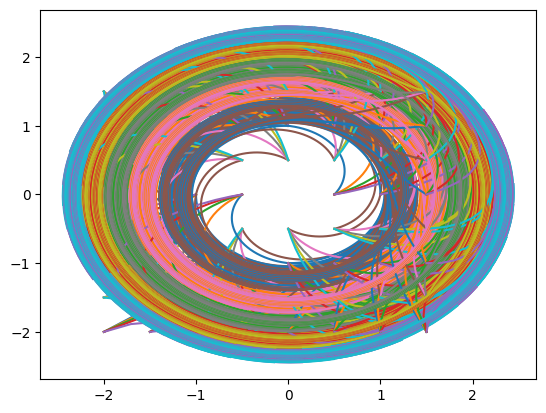

In [10]:
for i in range(ic.shape[0]):
    plt.plot(sol[:, i, 0], sol[:, i, 1])

In [11]:
training_data_tensor = sol.unsqueeze(0)
t_eval_tensor = torch.tensor( np.arange(t_span[0], t_span[1], dt), dtype=torch.float32 ).unsqueeze(0)

In [12]:
print(training_data_tensor.shape, t_eval_tensor.shape)

torch.Size([1, 200, 320, 3]) torch.Size([1, 200])


# Neural ODE - 

In [13]:
class NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        out = self.network(x) #(num_traj, spatial_dim+drivers)
        return out

In [14]:
model = NODE(input_dim=lc.system_dim+1, output_dim=lc.system_dim+1, depth=8, width=40, activation_func=nn.Tanh())  

In [15]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()




In [16]:
training_data_tensor.shape, t_eval_tensor.shape

(torch.Size([1, 200, 320, 3]), torch.Size([1, 200]))

num_epochs = 1000


for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Predicting the trajectory
    pred_x_list = []
    for i in range(t_eval_tensor.shape[0]):
        pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
        pred_x_list.append(pred_x_temp)

    pred_x = torch.stack(pred_x_list, dim=0)

    # Calculating loss
    loss = loss_fn(pred_x, training_data_tensor) 
    loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

## Load Model

In [17]:
model = torch.load('hopf_node_model_v6.pth', weights_only=False)


# Analysis of Trained Model 

In [ ]:
## Loss
pred_x_list = []
for i in range(t_eval_tensor.shape[0]):
    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn(pred_x, training_data_tensor)


tensor(0.0179, grad_fn=<MseLossBackward0>)

# Analysis of Trained Model

## Test Trajectories

In [22]:
r_vals = torch.arange(-1.0, 10.0, 1)

a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b, r_vals)

t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
node_data = odeint(model, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.na_f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})

## Time Trace

In [23]:
t = t_eval_pred.detach().numpy()
x = node_data.detach().numpy()[:, 201, :]
x_true = true_data.detach().numpy()[:, 201, :]

In [26]:
x.shape

(400, 3)

In [35]:
def cartesian_to_polar(x, y):
    """
    Convert Cartesian coordinates to polar coordinates.
    
    Parameters:
    x, y: float or array-like
        Cartesian coordinates
    
    Returns:
    r: float or array
        Radius (distance from origin)
    theta: float or array
        Angle in radians (from positive x-axis)
    """
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    """
    Convert polar coordinates to Cartesian coordinates.
    
    Parameters:
    r: float or array-like
        Radius (distance from origin)
    theta: float or array-like
        Angle in radians (from positive x-axis)
    
    Returns:
    x, y: float or array
        Cartesian coordinates
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

In [38]:
r, theta = cartesian_to_polar(x[:, 0], x[:, 1])
r_true, theta_true = cartesian_to_polar(x_true[:, 0], x_true[:, 1])


C:\Users\jackr\AppData\Local\Temp\ipykernel_27812\3089097437.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


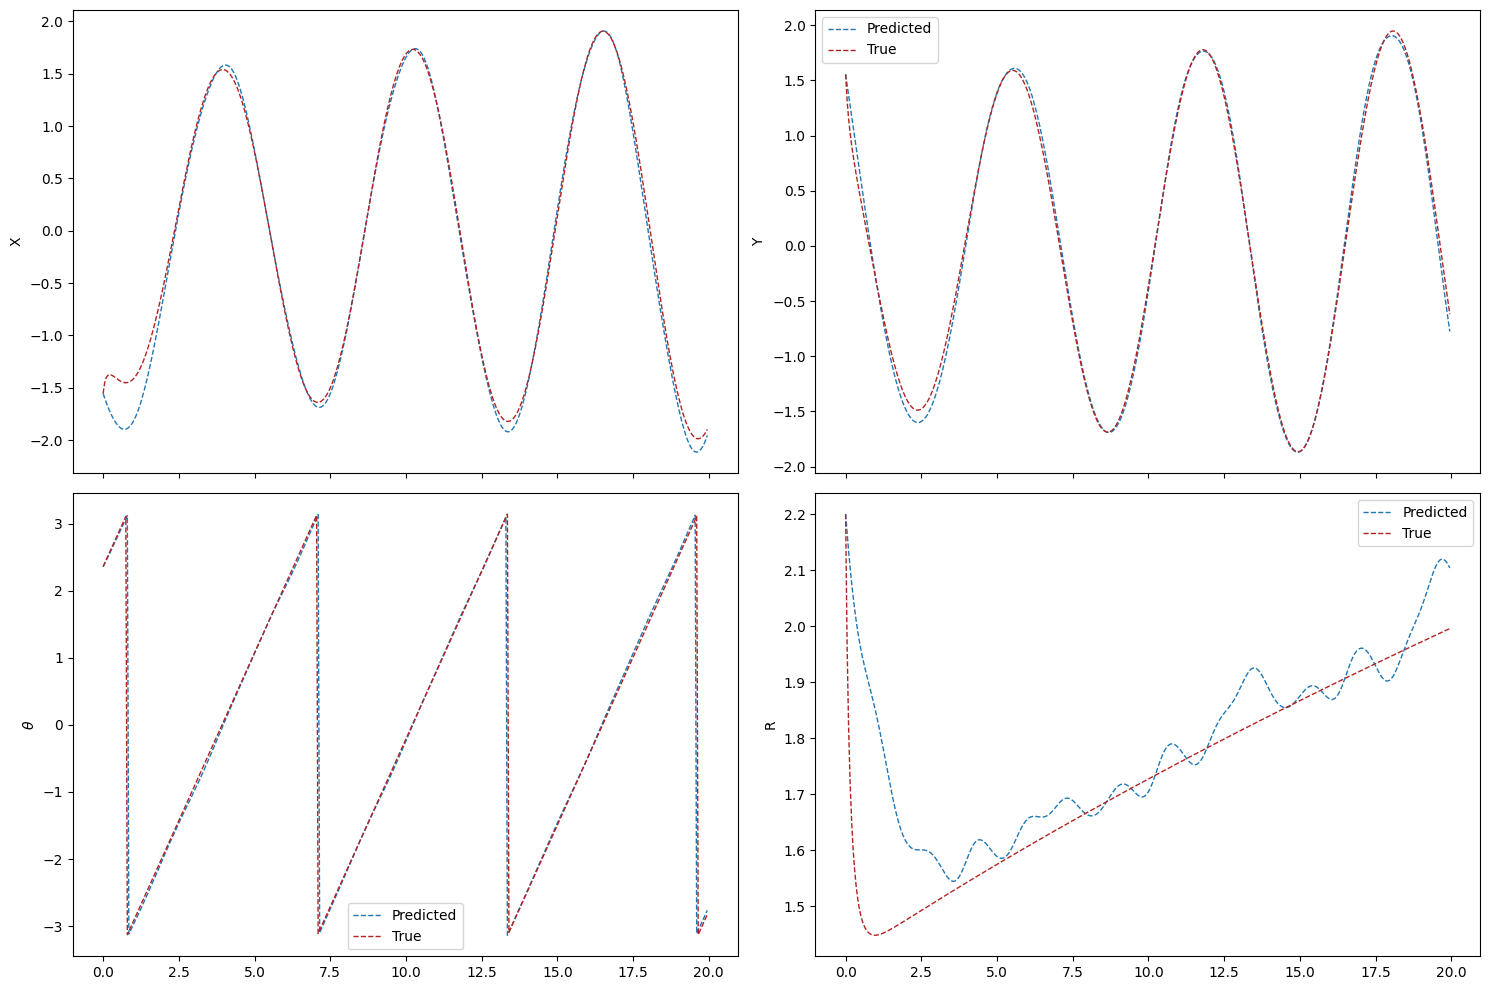

In [46]:


fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)


axes[0, 0].plot(t,
                x[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 0].plot(t, x_true[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 0].set_ylabel('X')

axes[0, 1].legend()


axes[0, 1].plot(t,
                x[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 1].plot(t, x_true[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 1].set_ylabel('Y')
axes[0, 1].legend()

axes[1, 1].plot(t,
                r,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 1].plot(t, r_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 1].set_ylabel('R')
axes[1, 1].legend()


axes[1, 0].plot(t,
                theta,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 0].plot(t, theta_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 0].set_ylabel(r'$\theta$')
axes[1, 0].legend()
plt.tight_layout()
plt.show()

### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

#Plotting results
fig = plt.figure(figsize=(10, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1)
for i in range(pts.shape[0]):
    ax1.arrow(x=true_data[0, i, 0].detach().numpy(), y=true_data[0, i, 1].detach().numpy(), 
          dx=true_data[10, i, 0].detach().numpy() - true_data[0, i, 0].detach().numpy(), 
          dy=true_data[10, i, 1].detach().numpy() - true_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')


#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2)
for i in range(pts.shape[0]):
    ax2.arrow(x=node_data[0, i, 0].detach().numpy(), y=node_data[0, i, 1].detach().numpy(), 
          dx=node_data[10, i, 0].detach().numpy() - node_data[0, i, 0].detach().numpy(), 
          dy=node_data[10, i, 1].detach().numpy() - node_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')

    



plt.show()

## Plots by $\rho$

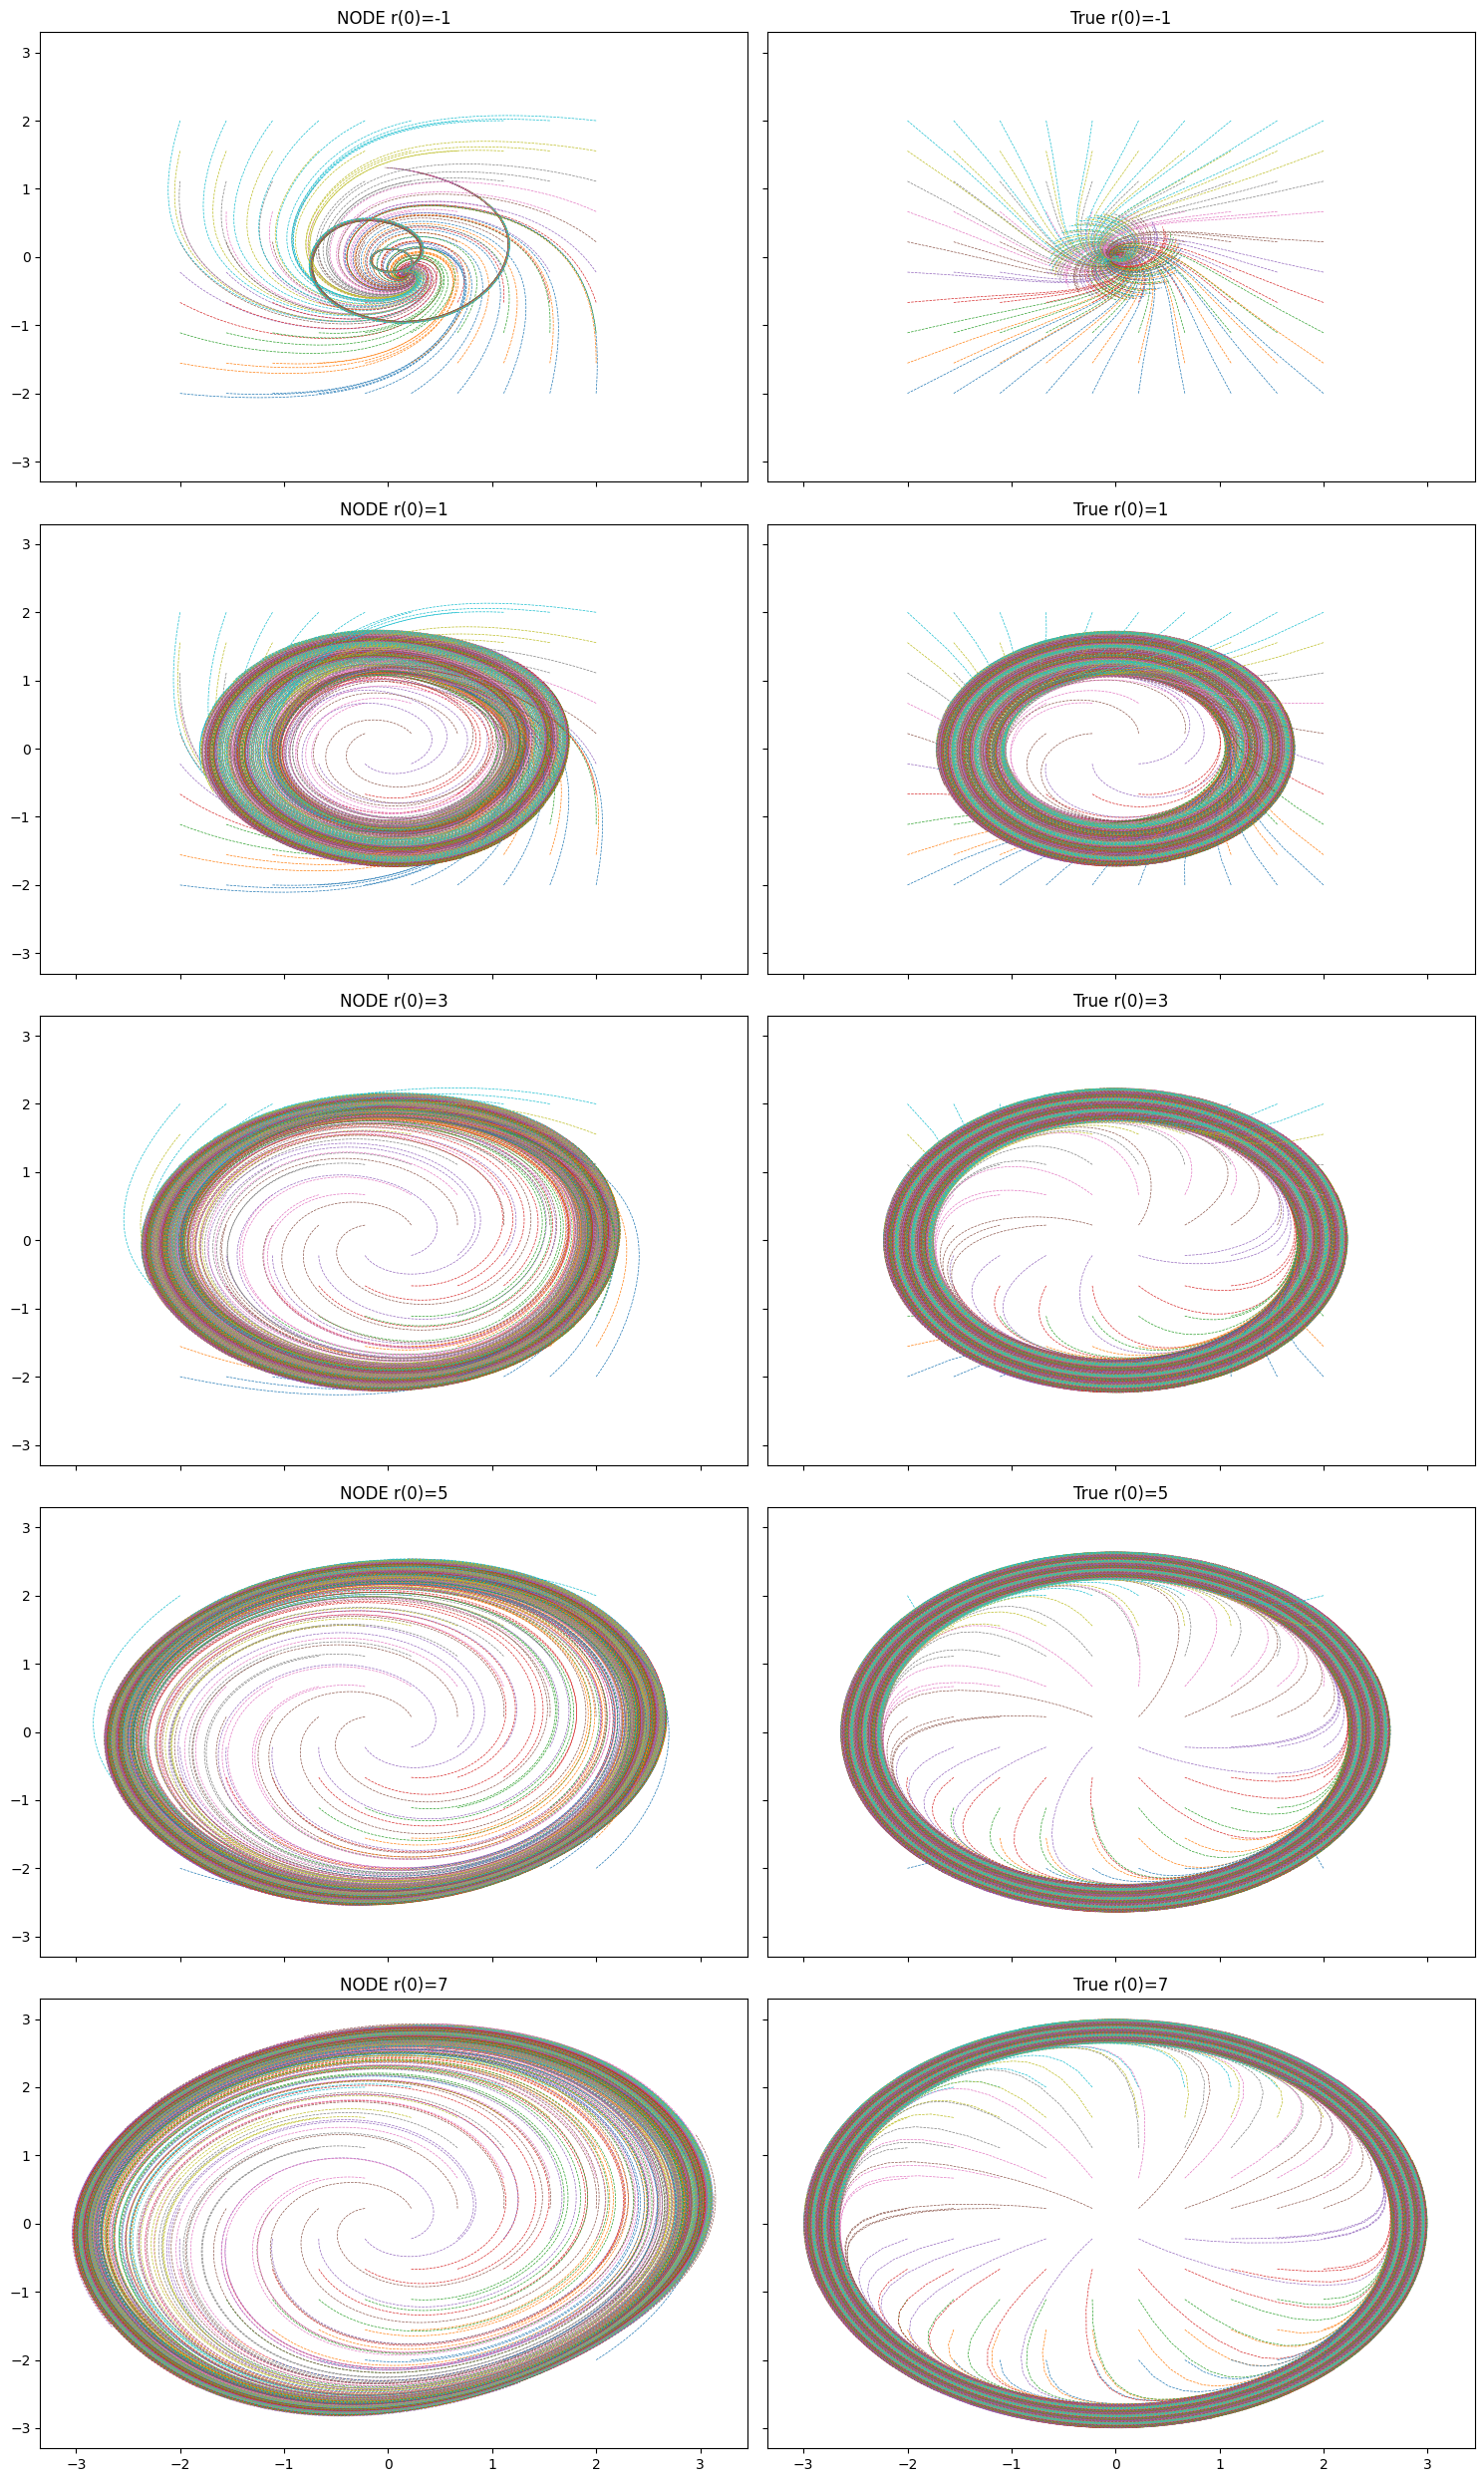

In [33]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    node_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    true_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

In [63]:
node_data[:, 200, :]

tensor([[-1.5556,  1.5556,  1.0000],
        [-1.5739,  1.4522,  1.0103],
        [-1.5906,  1.3495,  1.0204],
        ...,
        [-1.7449, -0.4365,  3.0115],
        [-1.7192, -0.5230,  3.0158],
        [-1.6885, -0.6080,  3.0202]], grad_fn=<SelectBackward0>)

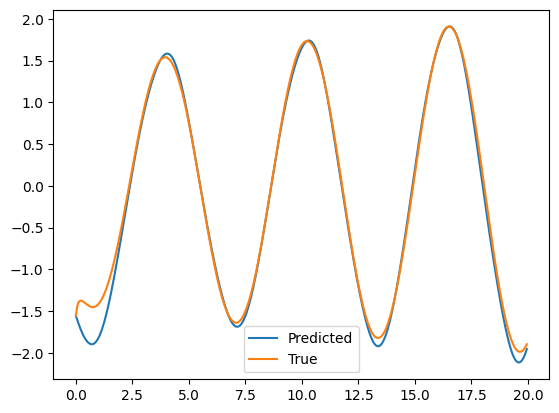

In [ ]:
t = t_eval_pred.detach().numpy()
x = node_data.detach().numpy()[:, 201, :]
x_true = true_data.detach().numpy()[:, 201, :]

plt.plot(t, x[:, 0], label='Predicted')
plt.plot(t, x_true[:, 0], label='True')
plt.legend()

In [22]:
# Interactive trajectory plot
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def plot_traj(idx=0):
    fig = plt.figure(figsize=(15, 8))
    r_val = r_vals[idx]
    print('rho = ', r_val.float())
    #First Plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(node_data[:, pts[:, 2] == r_val, 0].detach().numpy(), node_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(true_data[:, pts[:, 2] == r_val, 0].detach().numpy(), true_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')


In [23]:
interact(plot_traj, idx=IntSlider(min=0.0, max=r_vals.shape[0]-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=109), Output()), _dom_classes=('widget-interac…

<function __main__.plot_traj(idx=0)>

## Static $\rho $

In [23]:
def odewrapper(t, x):
    out = model(t, x)
    #out[:, 2] = torch.zeros_like(out[:, 2])
    out[:, 2] = 2*out[:, 2]
    return out

In [ ]:
r_vals = torch.arange(-1.0, 10.0, 0.1)

a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b, r_vals)

t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
node_data = odeint(odewrapper, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.na_f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})

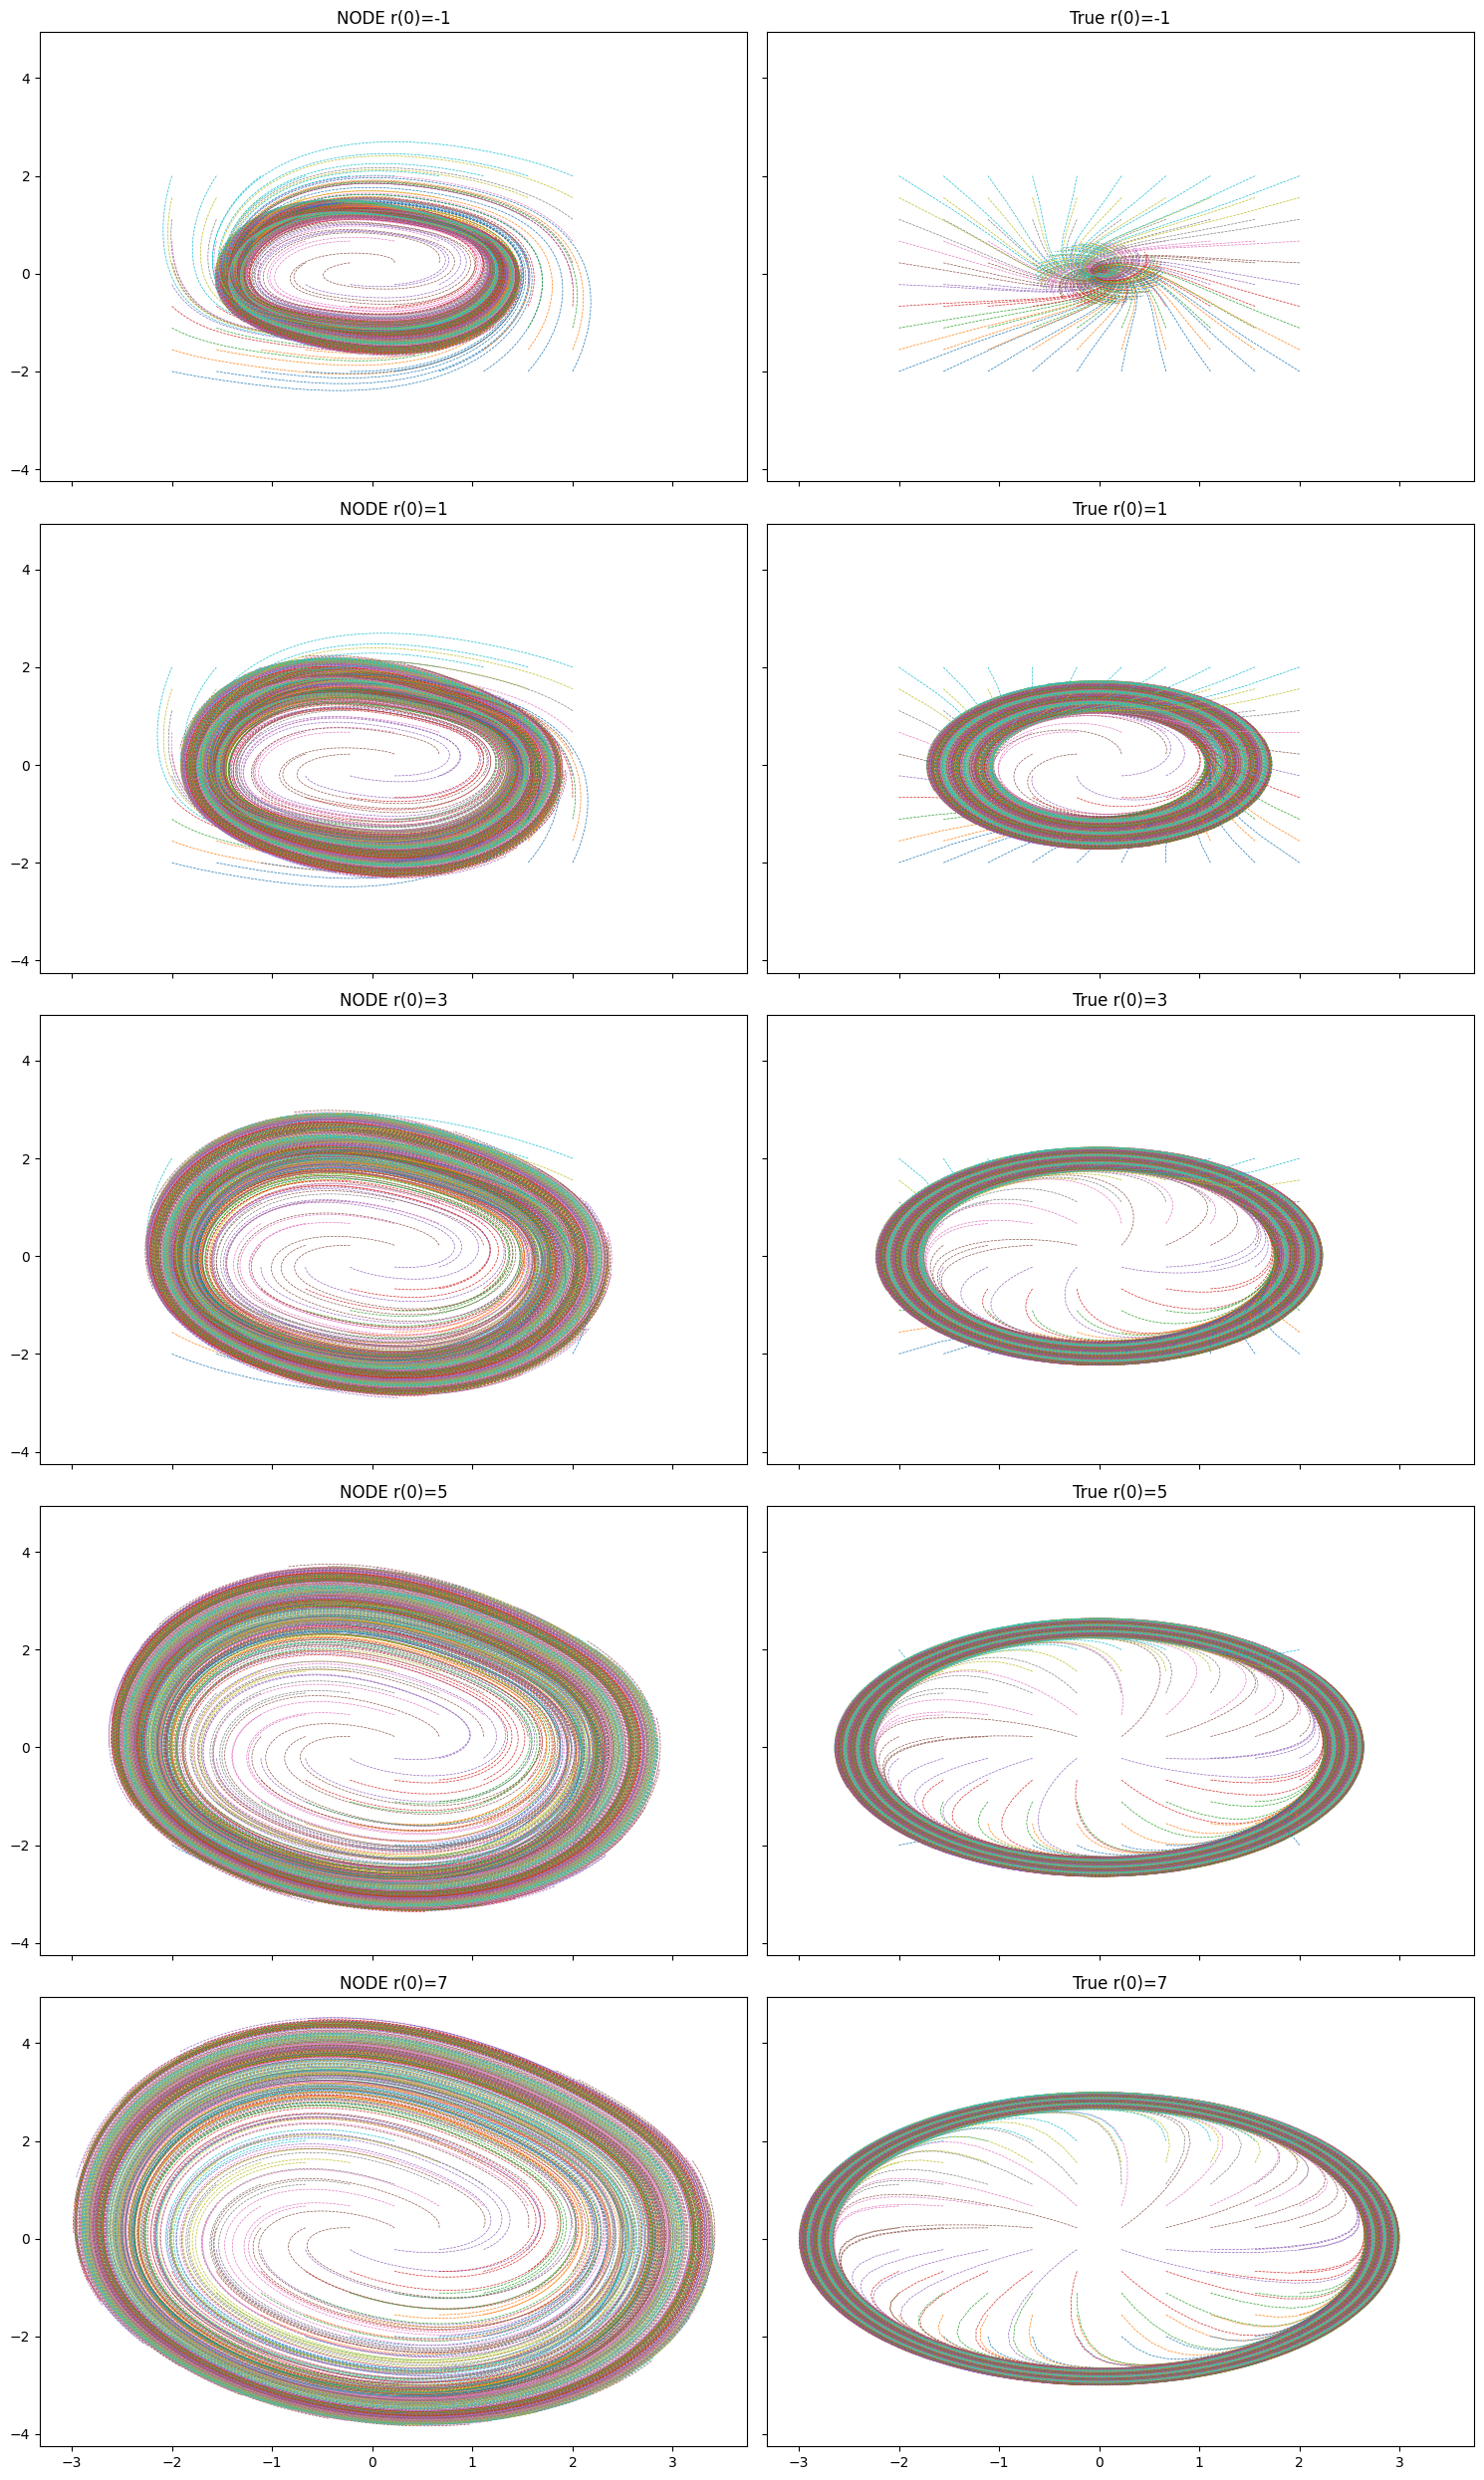

In [ ]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    node_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    true_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

torch.Size([100, 3])

In [ ]:
def odewrapper2(t, x):
    out = model(t, x)
    out[:, 2] = 2*out[:, 2]
    return out

def odewrapper3(t, x):
    out = model(t, x)
    return out

def odewrapper(t, x):
    out = model(t, x)
    out[:, 2] = torch.zeros_like(out[:, 2])
    #out[:, 2] = 2*out[:, 2]
    return out

In [ ]:
node_data_static = odeint(odewrapper, pts[pts[:, 2] == -1, :], t_eval_pred, method='rk4', options={'step_size': dt_pred})
node_data_dynamic = odeint(odewrapper3, pts[pts[:, 2] == 2, :], t_eval_pred, method='rk4', options={'step_size': dt_pred})
node_data_fast = odeint(odewrapper2, pts[pts[:, 2] == 2, :], t_eval_pred, method='rk4', options={'step_size': dt_pred})

Text(0.5, 1.0, '$2 \\dot \\rho$')

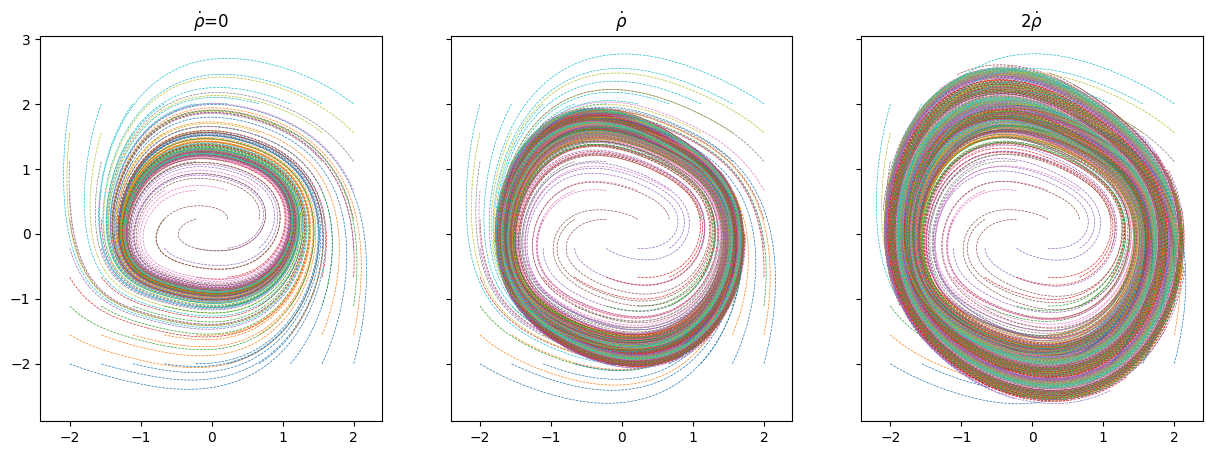

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].plot(node_data_static[:, :,  0].detach().numpy(),
                node_data_static[:, :,  1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[1].plot(node_data_dynamic[:, :, 0].detach().numpy(),
                node_data_dynamic[:, :, 1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[2].plot(node_data_fast[:, :, 0].detach().numpy(),
                node_data_fast[:, :, 1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[0].set_title(r'$\dot \rho$'+f"=0")
axes[1].set_title(r'$\dot \rho$')
axes[2].set_title(r'$2 \dot \rho$')

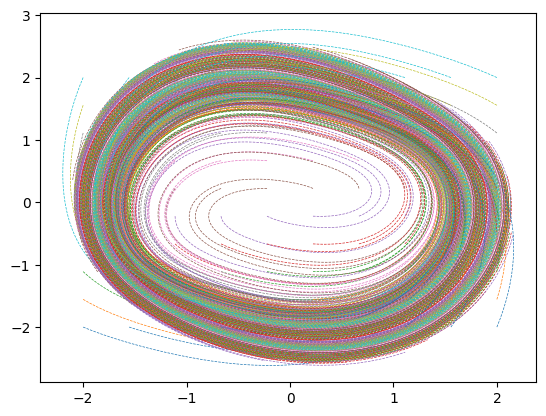

In [54]:
plt.plot(node_data_static[:, :, 0].detach().numpy(), node_data_static[:, :, 1].detach().numpy(),
          linewidth=0.5, alpha=1, linestyle='--')